# Telco Customer Churn

In [24]:
# set task name
task_name = 'telco_churn-v2'

# load common
%run common.ipynb

Cortex Python SDK v6.2.0
Cortex Discovery Libraries v3.5.14


In [26]:
from ds_discovery import ModelsBuilder
from ds_discovery import Wrangle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


## Model Run

In [27]:

ml = ModelsBuilder.from_env(task_name, has_contract=False)
uri = Wrangle.from_env(task_name).get_persist_contract().uri
ml.set_source_uri(uri=uri)
ml.pm_persist()

In [28]:
wr = Wrangle.from_env(task_name)
df = wr.load_persist_canonical()

In [29]:
# predictors
X = df.drop(['Churn', 'CustomerID'], axis=1)
# target
y = df['Churn']

In [30]:
df.head()

,CustomerID,Churn,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,ChurnRate,Churn_Score,CLTV,Count,Zip_Code,Latitude,Longitude,Age,Under_30,Married,Referred_a_Friend,Number_of_Referrals,Avg_Monthly_Long_Distance_Charges,Avg_Monthly_GB_Download,Streaming_Music,Premium_Tech_Support,Unlimited_Data,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Satisfaction_Score,Churn_Score.1,Contract_One year,Contract_Two year,City_Acton,City_Adelanto,City_Aguanga,City_Alameda,City_Alamo,City_Alhambra,City_Alleghany,City_Altadena,City_Alviso,City_Anaheim,City_Anderson,City_Angels Camp,City_Angelus Oaks,City_Angwin,...,"Lat_Long_41.027281, -120.669427","Lat_Long_41.042003, -120.506086","Lat_Long_41.081847, -122.700545","Lat_Long_41.082472, -121.195215","Lat_Long_41.096569, -121.879082","Lat_Long_41.121108, -122.336613","Lat_Long_41.162295, -124.027381","Lat_Long_41.171578, -120.913161","Lat_Long_41.212695, -122.392067","Lat_Long_41.232128, -123.194748","Lat_Long_41.266008, -120.490731","Lat_Long_41.269521, -123.546958","Lat_Long_41.33832, -122.290756","Lat_Long_41.388397, -122.794636","Lat_Long_41.411315, -122.697236","Lat_Long_41.444606, -123.471895","Lat_Long_41.486953, -120.913975","Lat_Long_41.528541, -122.955018","Lat_Long_41.5837, -122.935922","Lat_Long_41.599978, -122.539381","Lat_Long_41.750354, -120.403885","Lat_Long_41.816595, -122.948287","Lat_Long_41.831901, -123.487478","Lat_Long_41.932207, -120.135941",Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,InternetService_Fiber optic,InternetService_No,MultipleLines_No phone service,MultipleLines_Yes,Gender_Male,StreamingMovies_No internet service,StreamingMovies_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No internet service,TechSupport_Yes,Churn_Category_Attitude,Churn_Category_Competitor,Churn_Category_Dissatisfaction,Churn_Category_Other,Churn_Category_Price,StreamingTV_No internet service,StreamingTV_Yes
0,1548999,False,0.235,1.000,0.000,68.703,1.000,1.000,37.793,952.270,0.000,78.104,6294.063,1.000,95208.640,34.968,-119.984,46.081,0.000,1.000,1.000,0.882,6.742,2.106,0.000,0.000,1.000,11.384,18.527,530.883,2712.995,3.020,78.104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,6233499,True,0.255,0.000,1.000,10.814,1.000,0.000,72.377,4649.703,0.000,33.190,4740.714,1.000,93092.118,37.189,-121.580,22.665,0.000,0.000,0.000,4.770,27.669,6.889,1.000,1.000,0.000,3.214,9.509,773.179,6420.537,3.782,33.190,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
2,4991499,False,0.263,1.000,0.000,60.524,1.000,1.000,82.508,2275.357,0.000,72.652,5783.208,1.000,95655.934,32.582,-120.283,34.450,0.000,1.000,1.000,2.960,18.571,27.167,0.000,0.000,1.000,10.450,38.095,536.972,244.740,3.608,72.652,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
3,4122999,True,0.215,0.000,0.000,14.778,1.000,0.000,52.128,2345.154,0.000,33.460,4639.159,1.000,92333.559,37.975,-120.935,27.224,0.000,0.000,0.000,0.346,29.671,6.264,0.000,0.000,1.000,11.604,7.716,535.389,724.612,4.056,33.460,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
4,1719999,False,0.134,1.000,0.000,55.793,1.000,1.000,43.705,1410.086,0.000,56.706,5487.726,1.000,94313.786,35.021,-119.287,58.043,0.000,1.000,1.000,0.687,8.706,12.659,0.000,0.000,1.000,2.884,35.686,62.845,2909.822,3.497,56.706,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [31]:
df["TotalCharges"] = df["TotalCharges"].replace(" ", 0).astype("float32")
df["Satisfaction Score"] = df["Satisfaction_Score"].astype("object")
df["SeniorCitizen"] = df["SeniorCitizen"].replace(0, "0").replace(1, "1") 

In [32]:
df.head()

,CustomerID,Churn,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,ChurnRate,Churn_Score,CLTV,Count,Zip_Code,Latitude,Longitude,Age,Under_30,Married,Referred_a_Friend,Number_of_Referrals,Avg_Monthly_Long_Distance_Charges,Avg_Monthly_GB_Download,Streaming_Music,Premium_Tech_Support,Unlimited_Data,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Satisfaction_Score,Churn_Score.1,Contract_One year,Contract_Two year,City_Acton,City_Adelanto,City_Aguanga,City_Alameda,City_Alamo,City_Alhambra,City_Alleghany,City_Altadena,City_Alviso,City_Anaheim,City_Anderson,City_Angels Camp,City_Angelus Oaks,City_Angwin,...,"Lat_Long_41.042003, -120.506086","Lat_Long_41.081847, -122.700545","Lat_Long_41.082472, -121.195215","Lat_Long_41.096569, -121.879082","Lat_Long_41.121108, -122.336613","Lat_Long_41.162295, -124.027381","Lat_Long_41.171578, -120.913161","Lat_Long_41.212695, -122.392067","Lat_Long_41.232128, -123.194748","Lat_Long_41.266008, -120.490731","Lat_Long_41.269521, -123.546958","Lat_Long_41.33832, -122.290756","Lat_Long_41.388397, -122.794636","Lat_Long_41.411315, -122.697236","Lat_Long_41.444606, -123.471895","Lat_Long_41.486953, -120.913975","Lat_Long_41.528541, -122.955018","Lat_Long_41.5837, -122.935922","Lat_Long_41.599978, -122.539381","Lat_Long_41.750354, -120.403885","Lat_Long_41.816595, -122.948287","Lat_Long_41.831901, -123.487478","Lat_Long_41.932207, -120.135941",Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,InternetService_Fiber optic,InternetService_No,MultipleLines_No phone service,MultipleLines_Yes,Gender_Male,StreamingMovies_No internet service,StreamingMovies_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No internet service,TechSupport_Yes,Churn_Category_Attitude,Churn_Category_Competitor,Churn_Category_Dissatisfaction,Churn_Category_Other,Churn_Category_Price,StreamingTV_No internet service,StreamingTV_Yes,Satisfaction Score
0,1548999,False,0.235,1.000,0.000,68.703,1.000,1.000,37.793,952.270,0.000,78.104,6294.063,1.000,95208.640,34.968,-119.984,46.081,0.000,1.000,1.000,0.882,6.742,2.106,0.000,0.000,1.000,11.384,18.527,530.883,2712.995,3.020,78.104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,3.020
1,6233499,True,0.255,0.000,1.000,10.814,1.000,0.000,72.377,4649.703,0.000,33.190,4740.714,1.000,93092.118,37.189,-121.580,22.665,0.000,0.000,0.000,4.770,27.669,6.889,1.000,1.000,0.000,3.214,9.509,773.179,6420.537,3.782,33.190,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,3.782
2,4991499,False,0.263,1.000,0.000,60.524,1.000,1.000,82.508,2275.357,0.000,72.652,5783.208,1.000,95655.934,32.582,-120.283,34.450,0.000,1.000,1.000,2.960,18.571,27.167,0.000,0.000,1.000,10.450,38.095,536.972,244.740,3.608,72.652,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,3.608
3,4122999,True,0.215,0.000,0.000,14.778,1.000,0.000,52.128,2345.154,0.000,33.460,4639.159,1.000,92333.559,37.975,-120.935,27.224,0.000,0.000,0.000,0.346,29.671,6.264,0.000,0.000,1.000,11.604,7.716,535.389,724.612,4.056,33.460,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,4.056
4,1719999,False,0.134,1.000,0.000,55.793,1.000,1.000,43.705,1410.086,0.000,56.706,5487.726,1.000,94313.786,35.021,-119.287,58.043,0.000,1.000,1.000,0.687,8.706,12.659,0.000,0.000,1.000,2.884,35.686,62.845,2909.822,3.497,56.706,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,3.497


In [33]:
X.head()
y.head()

,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,ChurnRate,Churn_Score,CLTV,Count,Zip_Code,Latitude,Longitude,Age,Under_30,Married,Referred_a_Friend,Number_of_Referrals,Avg_Monthly_Long_Distance_Charges,Avg_Monthly_GB_Download,Streaming_Music,Premium_Tech_Support,Unlimited_Data,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Satisfaction_Score,Churn_Score.1,Contract_One year,Contract_Two year,City_Acton,City_Adelanto,City_Aguanga,City_Alameda,City_Alamo,City_Alhambra,City_Alleghany,City_Altadena,City_Alviso,City_Anaheim,City_Anderson,City_Angels Camp,City_Angelus Oaks,City_Angwin,City_Antelope,City_Anza,...,"Lat_Long_41.027281, -120.669427","Lat_Long_41.042003, -120.506086","Lat_Long_41.081847, -122.700545","Lat_Long_41.082472, -121.195215","Lat_Long_41.096569, -121.879082","Lat_Long_41.121108, -122.336613","Lat_Long_41.162295, -124.027381","Lat_Long_41.171578, -120.913161","Lat_Long_41.212695, -122.392067","Lat_Long_41.232128, -123.194748","Lat_Long_41.266008, -120.490731","Lat_Long_41.269521, -123.546958","Lat_Long_41.33832, -122.290756","Lat_Long_41.388397, -122.794636","Lat_Long_41.411315, -122.697236","Lat_Long_41.444606, -123.471895","Lat_Long_41.486953, -120.913975","Lat_Long_41.528541, -122.955018","Lat_Long_41.5837, -122.935922","Lat_Long_41.599978, -122.539381","Lat_Long_41.750354, -120.403885","Lat_Long_41.816595, -122.948287","Lat_Long_41.831901, -123.487478","Lat_Long_41.932207, -120.135941",Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,InternetService_Fiber optic,InternetService_No,MultipleLines_No phone service,MultipleLines_Yes,Gender_Male,StreamingMovies_No internet service,StreamingMovies_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No internet service,TechSupport_Yes,Churn_Category_Attitude,Churn_Category_Competitor,Churn_Category_Dissatisfaction,Churn_Category_Other,Churn_Category_Price,StreamingTV_No internet service,StreamingTV_Yes
0,0.235,1.000,0.000,68.703,1.000,1.000,37.793,952.270,0.000,78.104,6294.063,1.000,95208.640,34.968,-119.984,46.081,0.000,1.000,1.000,0.882,6.742,2.106,0.000,0.000,1.000,11.384,18.527,530.883,2712.995,3.020,78.104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.255,0.000,1.000,10.814,1.000,0.000,72.377,4649.703,0.000,33.190,4740.714,1.000,93092.118,37.189,-121.580,22.665,0.000,0.000,0.000,4.770,27.669,6.889,1.000,1.000,0.000,3.214,9.509,773.179,6420.537,3.782,33.190,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
2,0.263,1.000,0.000,60.524,1.000,1.000,82.508,2275.357,0.000,72.652,5783.208,1.000,95655.934,32.582,-120.283,34.450,0.000,1.000,1.000,2.960,18.571,27.167,0.000,0.000,1.000,10.450,38.095,536.972,244.740,3.608,72.652,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
3,0.215,0.000,0.000,14.778,1.000,0.000,52.128,2345.154,0.000,33.460,4639.159,1.000,92333.559,37.975,-120.935,27.224,0.000,0.000,0.000,0.346,29.671,6.264,0.000,0.000,1.000,11.604,7.716,535.389,724.612,4.056,33.460,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
4,0.134,1.000,0.000,55.793,1.000,1.000,43.705,1410.086,0.000,56.706,5487.726,1.000,94313.786,35.021,-119.287,58.043,0.000,1.000,1.000,0.687,8.706,12.659,0.000,0.000,1.000,2.884,35.686,62.845,2909.822,3.497,56.706,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


0    False
1     True
2    False
3     True
4    False
Name: Churn, dtype: bool

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 1)

In [35]:
X_train.shape

(800, 1426)

In [36]:
X_test.shape

(200, 1426)

In [42]:
### Create Model

nn_model2 = Sequential()
nn_model2.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          input_dim=1426, activation='relu'))
##Dropout for not memorize or overfitting the train data
nn_model2.add(layers.Dropout(0.2)) 
nn_model2.add(layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          input_dim=1426, activation='relu'))
nn_model2.add(layers.Dropout(0.1)) 
nn_model2.add(layers.Dense(1, activation='sigmoid'))

In [43]:
# Training

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.0001, 
                                                            decay_steps=(X_train.shape[0]/32)*50,
                                                            decay_rate=1,
                                                            staircase=False)
##Time decay means for every 50 epochs the learning rate will be half of 0.001 value
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)
def get_callbacks():
    return
[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                  patience=70, restore_best_weights=True)]

nn_model2.compile(loss='binary_crossentropy', optimizer=get_optimizer(), 
                 metrics=['accuracy'])
nn_model2.summary()

history = nn_model2.fit(X_train, y_train, validation_data = (X_test, y_test),
                       epochs = 150, batch_size=32, callbacks = get_callbacks(),
                       verbose=0)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                91328     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 8)                 520       
                                                                 
 dropout_19 (Dropout)        (None, 8)                 0         
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 91,857
Trainable params: 91,857
Non-trainable params: 0
_________________________________________________________________


2022-12-28 13:42:00.747395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-28 13:42:01.200195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [44]:
warnings.filterwarnings("ignore")

<Figure size 1200x700 with 0 Axes>

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochen')

Text(0, 0.5, 'Accuracy')

<Figure size 640x480 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochen')

Text(0, 0.5, 'Loss')

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

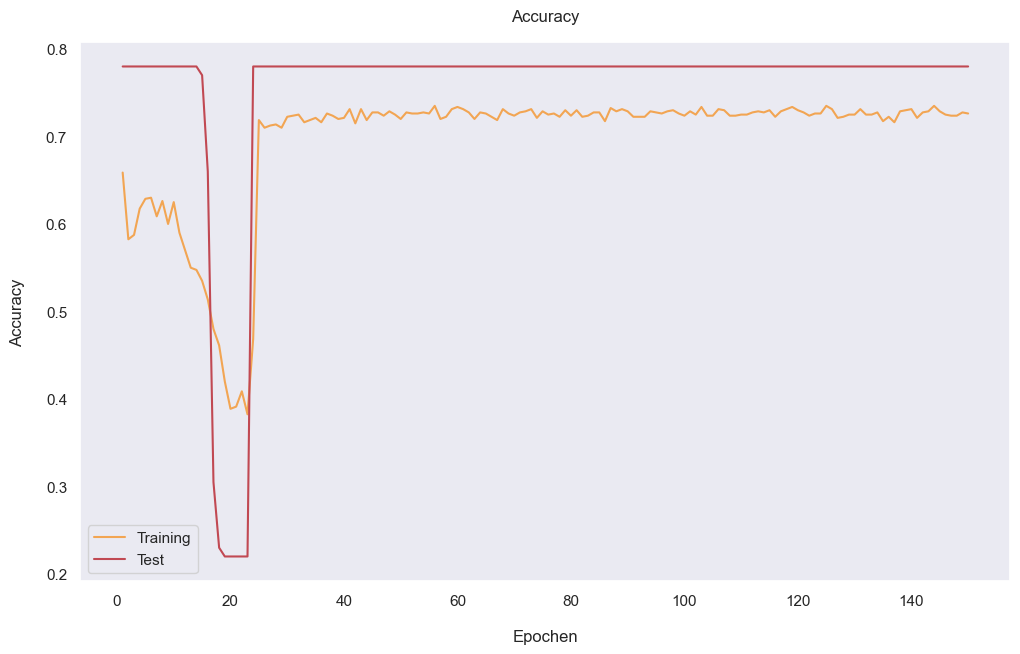

<Figure size 640x480 with 0 Axes>

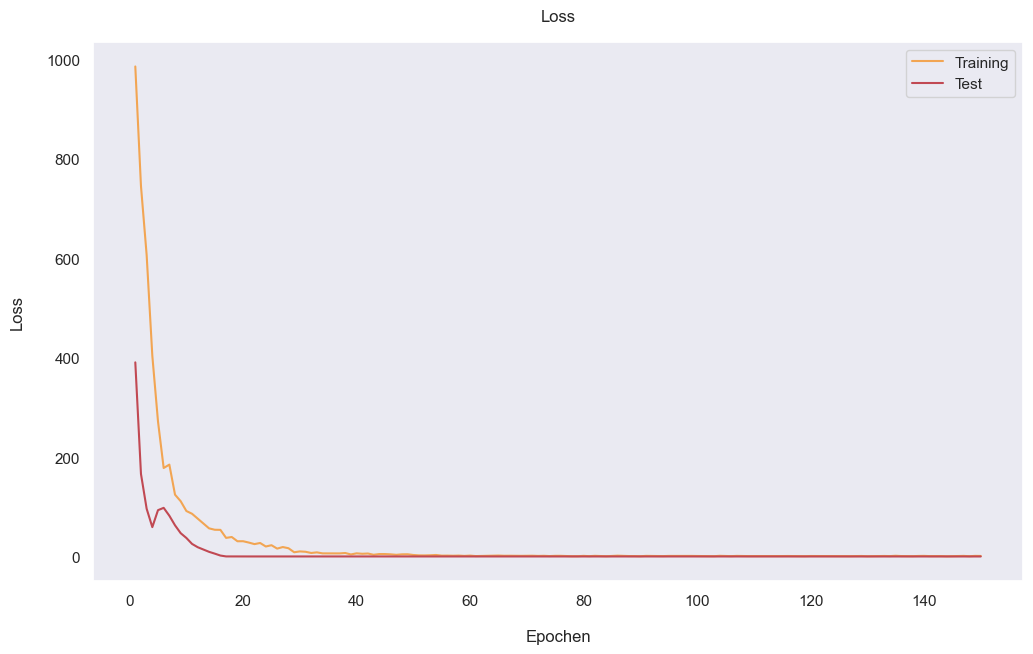

In [45]:
# Training process

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
 
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,7))
plt.plot(epochs, acc, color='#f2a553', label='Training')
plt.plot(epochs, val_acc, 'b', color='#c14953', label='Test')
plt.title('Accuracy', pad = 15)
plt.grid(False)
plt.xlabel('Epochen', labelpad = 15)
plt.ylabel('Accuracy', labelpad = 15)
plt.legend()
plt.figure()

plt.figure(figsize=(12,7)) 
plt.plot(epochs, loss, color='#f2a553', label='Training')
plt.plot(epochs, val_loss, 'b', color='#c14953', label='Test')
plt.title('Loss', pad = 15)
plt.grid(False)
plt.xlabel('Epochen', labelpad = 15)
plt.ylabel('Loss', labelpad = 15)
plt.legend()
plt.figure


In [46]:
# Evaluation

accuracy = nn_model2.evaluate(X_train, y_train, verbose=False)
print("Training Score: {:.4f}".format(accuracy[0]))
print("Training Accuracy: {:.4f}".format(accuracy[1]))

accuracy = nn_model2.evaluate(X_test, y_test, verbose=False)
print("Testing Score: {:.4f}".format(accuracy[0]))
print("Testing Accuracy: {:.4f}".format(accuracy[1]))


Training Score: 0.6693
Training Accuracy: 0.7337
Testing Score: 0.6633
Testing Accuracy: 0.7800


7/7 [==============================] - 0s 3ms/step


<Figure size 1200x700 with 0 Axes>

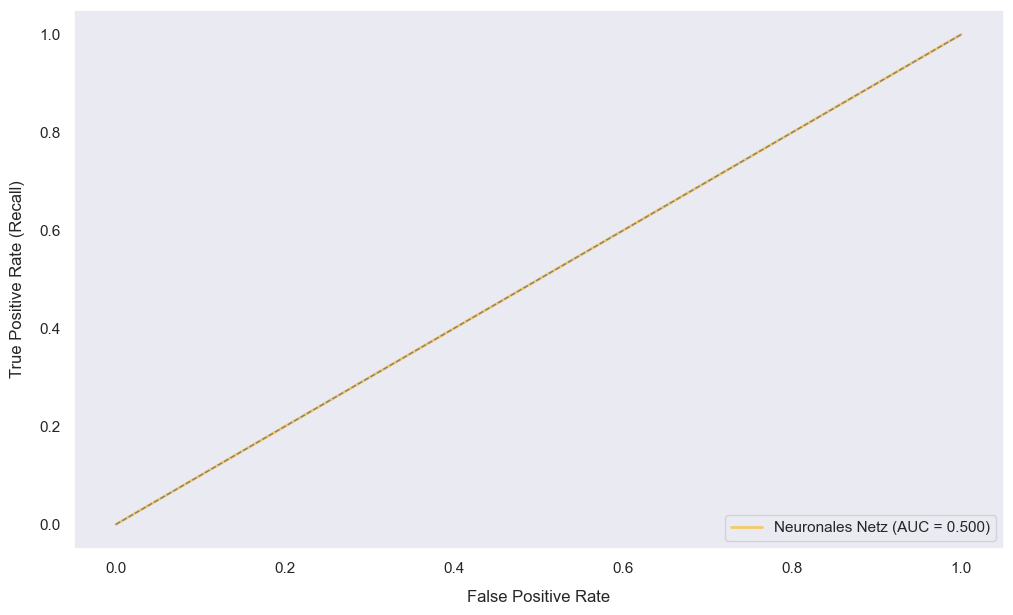

In [51]:
# make predictions for test dataset
X_test_np=X_test.to_numpy() # np = numpy
X_test_np_r=X_test_np.reshape(200,1426) # r = reshape
#print(X_test_np_r)

yprednn_r_test = nn_model2.predict(X_test_np_r)
#print(yprednn_r_test)

# ROC Curve Input NN
y_scores_nn = yprednn_r_test
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_scores_nn)

# Plot ROC Curve
plt.figure(figsize=(12,7))
def plot_roc_curve(fpr, tpr, label=None, color=None):
    plt.plot(fpr, tpr, linewidth=2, label=label, color=color)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.0, color="gray") # Dashed diagonal
    plt.xlabel('False Positive Rate', labelpad = 10)
    plt.ylabel('True Positive Rate (Recall)', labelpad = 10)
    plt.legend(loc="lower right")
    plt.grid(False)
    
plot_roc_curve(fpr_nn, tpr_nn, "Neuronales Netz (AUC = %0.3f)" % (roc_auc_score(y_test, y_scores_nn)), "#f3c969")